# Pattern Search Tree for Optimal Lattice-Decoder Configurations

This notebook implements a search tree algorithm to find the best gradient/pattern shapes
for initializing a 3D lattice that connects to a decoder network.

## Overview
1. Define pattern search space (primitives, gradients, compositions)
2. Build a decoder network that reconstructs from lattice states
3. Implement tree search with pruning based on reconstruction quality
4. Visualize search results and identify optimal configurations

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional, Any, Callable
from collections import defaultdict
import heapq
import time
from tqdm.auto import tqdm

# Local imports
from tensor_lattice import Tensor3DLattice, DifferentiableTensor3DLattice
from lattice_patterns import PatternGenerator, Pattern3D

# Device setup
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

Using device: mps


## 1. Configuration

In [2]:
# Lattice configuration
LATTICE_SHAPE = (16, 16, 16)  # 3D lattice dimensions
TOPOLOGY = 'toroidal'  # 'bounded', 'toroidal', 'cylindrical'
CONNECTIVITY = '6-connected'  # '6-connected', '18-connected', '26-connected'

# Decoder configuration
INPUT_DIM = 784  # e.g., flattened 28x28 MNIST
OUTPUT_DIM = 784
HIDDEN_DIM = 256

# Search configuration
MAX_SEARCH_DEPTH = 3  # Maximum composition depth
BEAM_WIDTH = 5  # Number of top candidates to expand at each level
TRAIN_EPOCHS = 10  # Quick training epochs per candidate
BATCH_SIZE = 64
LEARNING_RATE = 1e-3

# Create pattern generator
pg = PatternGenerator(shape=LATTICE_SHAPE)

print(f"Lattice shape: {LATTICE_SHAPE}")
print(f"Total cells: {np.prod(LATTICE_SHAPE)}")
print(f"Search depth: {MAX_SEARCH_DEPTH}, Beam width: {BEAM_WIDTH}")

Lattice shape: (16, 16, 16)
Total cells: 4096
Search depth: 3, Beam width: 5


## 2. Define Pattern Search Space

In [3]:
@dataclass
class PatternNode:
    """A node in the pattern search tree."""
    name: str
    pattern: Pattern3D
    params: Dict[str, Any]
    score: float = 0.0
    depth: int = 0
    parent: Optional['PatternNode'] = None
    children: List['PatternNode'] = field(default_factory=list)
    
    def __lt__(self, other):
        # For heap operations (lower score = better, so we negate for max-heap behavior)
        return self.score > other.score
    
    def get_path(self) -> List[str]:
        """Get the path from root to this node."""
        path = []
        node = self
        while node is not None:
            path.append(node.name)
            node = node.parent
        return list(reversed(path))


class PatternSearchSpace:
    """Defines the search space of patterns and their compositions."""
    
    def __init__(self, pg: PatternGenerator):
        self.pg = pg
        
        # Define primitive patterns with parameter variations
        self.primitives = {
            # Geometric primitives
            'sphere_small': lambda: pg.sphere(radius=0.25),
            'sphere_medium': lambda: pg.sphere(radius=0.4),
            'sphere_large': lambda: pg.sphere(radius=0.6),
            'shell_thin': lambda: pg.shell(inner_radius=0.3, outer_radius=0.4),
            'shell_thick': lambda: pg.shell(inner_radius=0.2, outer_radius=0.5),
            
            # Gradients
            'grad_x': lambda: pg.gradient(axis='x'),
            'grad_y': lambda: pg.gradient(axis='y'),
            'grad_z': lambda: pg.gradient(axis='z'),
            'grad_radial': lambda: pg.radial_gradient(),
            'grad_radial_inv': lambda: pg.radial_gradient().invert(),
            
            # Waves
            'wave_x_low': lambda: pg.sine_wave(frequency=(1, 0, 0)),
            'wave_x_high': lambda: pg.sine_wave(frequency=(3, 0, 0)),
            'wave_z': lambda: pg.sine_wave(frequency=(0, 0, 2)),
            'wave_spherical': lambda: pg.spherical_wave(frequency=2),
            'spiral': lambda: pg.spiral(turns=2),
            
            # Structured patterns
            'checkerboard': lambda: pg.checkerboard(cell_size=4),
            'grid': lambda: pg.grid_lines(spacing=4, thickness=1),
            'dots': lambda: pg.dots(spacing=4, radius=1.5),
            
            # Special surfaces
            'gyroid': lambda: pg.gyroid(scale=2.0),
            
            # Noise
            'noise_fine': lambda: pg.noise(scale=0.3),
            'noise_coarse': lambda: pg.noise(scale=0.7),
            
            # Uniform baselines
            'ones': lambda: pg.ones(),
            'zeros': lambda: pg.zeros(),
        }
        
        # Composition operations
        self.compositions = ['add', 'multiply', 'max', 'blend']
    
    def get_primitive_patterns(self) -> List[PatternNode]:
        """Generate all primitive pattern nodes."""
        nodes = []
        for name, generator in self.primitives.items():
            pattern = generator()
            node = PatternNode(
                name=name,
                pattern=pattern,
                params={'type': 'primitive'},
                depth=0
            )
            nodes.append(node)
        return nodes
    
    def compose_patterns(self, node1: PatternNode, node2: PatternNode, 
                        operation: str) -> PatternNode:
        """Create a new pattern by composing two existing patterns."""
        if operation == 'add':
            new_pattern = (node1.pattern + node2.pattern).normalize()
        elif operation == 'multiply':
            new_pattern = (node1.pattern * node2.pattern).normalize()
        elif operation == 'max':
            max_data = np.maximum(node1.pattern.data, node2.pattern.data)
            new_pattern = Pattern3D(data=max_data, name='max', params={})
        elif operation == 'blend':
            new_pattern = self.pg.blend(node1.pattern, node2.pattern, blend_factor=0.5)
        else:
            raise ValueError(f"Unknown composition: {operation}")
        
        new_name = f"({node1.name} {operation} {node2.name})"
        new_depth = max(node1.depth, node2.depth) + 1
        
        return PatternNode(
            name=new_name,
            pattern=new_pattern,
            params={'type': 'composition', 'operation': operation,
                   'left': node1.name, 'right': node2.name},
            depth=new_depth,
            parent=node1
        )
    
    def expand_node(self, node: PatternNode, 
                    candidates: List[PatternNode]) -> List[PatternNode]:
        """Expand a node by composing it with other candidates."""
        expansions = []
        for other in candidates:
            if other.name == node.name:
                continue
            for op in self.compositions:
                new_node = self.compose_patterns(node, other, op)
                expansions.append(new_node)
        return expansions


# Initialize search space
search_space = PatternSearchSpace(pg)
primitives = search_space.get_primitive_patterns()
print(f"Primitive patterns: {len(primitives)}")
print(f"Composition operations: {search_space.compositions}")

Primitive patterns: 23
Composition operations: ['add', 'multiply', 'max', 'blend']


## 3. Decoder Network Architecture

In [4]:
class LatticeEncoder(nn.Module):
    """Encodes input into lattice cell activations."""
    
    def __init__(self, input_dim: int, lattice_shape: Tuple[int, ...], hidden_dim: int = 256):
        super().__init__()
        self.lattice_shape = lattice_shape
        self.n_cells = np.prod(lattice_shape)
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, self.n_cells),
            nn.Sigmoid()  # Output in [0, 1] for lattice cell values
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Encode input to lattice activations."""
        # x: (batch, input_dim) -> (batch, n_cells)
        return self.encoder(x)


class LatticeDecoder(nn.Module):
    """Decodes lattice states back to output."""
    
    def __init__(self, lattice_shape: Tuple[int, ...], output_dim: int, hidden_dim: int = 256):
        super().__init__()
        self.lattice_shape = lattice_shape
        self.n_cells = np.prod(lattice_shape)
        
        self.decoder = nn.Sequential(
            nn.Linear(self.n_cells, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
    
    def forward(self, lattice_state: torch.Tensor) -> torch.Tensor:
        """Decode lattice state to output."""
        # lattice_state: (batch, n_cells) -> (batch, output_dim)
        return self.decoder(lattice_state)


class LatticeAutoencoder(nn.Module):
    """Full autoencoder with lattice in the middle."""
    
    def __init__(self, input_dim: int, output_dim: int, 
                 lattice_shape: Tuple[int, ...], hidden_dim: int = 256,
                 pattern_weights: Optional[torch.Tensor] = None):
        super().__init__()
        self.lattice_shape = lattice_shape
        self.n_cells = np.prod(lattice_shape)
        
        self.encoder = LatticeEncoder(input_dim, lattice_shape, hidden_dim)
        self.decoder = LatticeDecoder(lattice_shape, output_dim, hidden_dim)
        
        # Pattern-based modulation of lattice activations
        if pattern_weights is not None:
            self.register_buffer('pattern_weights', pattern_weights.flatten())
        else:
            self.register_buffer('pattern_weights', torch.ones(self.n_cells))
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass through encoder, lattice modulation, and decoder."""
        # Encode to lattice
        lattice_state = self.encoder(x)
        
        # Apply pattern-based modulation
        modulated_state = lattice_state * self.pattern_weights.unsqueeze(0)
        
        # Decode back
        reconstruction = self.decoder(modulated_state)
        
        return reconstruction, modulated_state
    
    def set_pattern(self, pattern: Pattern3D):
        """Update the pattern weights."""
        weights = torch.from_numpy(pattern.data).float().flatten()
        self.pattern_weights = weights.to(self.pattern_weights.device)


print("Model classes defined!")

Model classes defined!


## 4. Training and Evaluation

In [5]:
def create_synthetic_data(n_samples: int = 1000, dim: int = 784, 
                          n_modes: int = 10) -> torch.Tensor:
    """Create synthetic multi-modal data for testing."""
    data = []
    samples_per_mode = n_samples // n_modes
    
    for i in range(n_modes):
        # Each mode is a different pattern
        center = torch.randn(dim) * 0.5
        samples = center + torch.randn(samples_per_mode, dim) * 0.1
        data.append(samples)
    
    data = torch.cat(data, dim=0)
    # Normalize to [0, 1]
    data = (data - data.min()) / (data.max() - data.min())
    return data


def load_mnist_data():
    """Load MNIST data if available, otherwise use synthetic."""
    try:
        from torchvision import datasets, transforms
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.view(-1))  # Flatten
        ])
        train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
        train_data = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
        print(f"Loaded MNIST: {train_data.shape}")
        return train_data
    except Exception as e:
        print(f"Could not load MNIST ({e}), using synthetic data")
        return create_synthetic_data(n_samples=5000, dim=INPUT_DIM)


# Load data
train_data = load_mnist_data()
print(f"Data shape: {train_data.shape}")
print(f"Data range: [{train_data.min():.3f}, {train_data.max():.3f}]")

Loaded MNIST: torch.Size([60000, 784])
Data shape: torch.Size([60000, 784])
Data range: [0.000, 1.000]


In [6]:
def evaluate_pattern(pattern_node: PatternNode, 
                     train_data: torch.Tensor,
                     epochs: int = TRAIN_EPOCHS,
                     batch_size: int = BATCH_SIZE,
                     verbose: bool = False) -> float:
    """Train a model with the given pattern and return reconstruction MSE."""
    
    # Create pattern weights tensor
    pattern_weights = torch.from_numpy(pattern_node.pattern.data).float()
    
    # Create model
    model = LatticeAutoencoder(
        input_dim=INPUT_DIM,
        output_dim=OUTPUT_DIM,
        lattice_shape=LATTICE_SHAPE,
        hidden_dim=HIDDEN_DIM,
        pattern_weights=pattern_weights
    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    
    # Training loop
    n_samples = len(train_data)
    indices = torch.randperm(n_samples)
    
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        n_batches = 0
        
        for i in range(0, n_samples, batch_size):
            batch_idx = indices[i:i+batch_size]
            batch = train_data[batch_idx].to(device)
            
            optimizer.zero_grad()
            reconstruction, _ = model(batch)
            loss = F.mse_loss(reconstruction, batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        scheduler.step()
        avg_loss = epoch_loss / n_batches
        losses.append(avg_loss)
        
        if verbose and (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}/{epochs}: Loss = {avg_loss:.6f}")
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        # Evaluate on subset
        eval_data = train_data[:1000].to(device)
        reconstruction, _ = model(eval_data)
        final_mse = F.mse_loss(reconstruction, eval_data).item()
    
    return final_mse


print("Evaluation function defined!")

Evaluation function defined!


## 5. Beam Search Algorithm

In [7]:
class PatternSearchTree:
    """Beam search over pattern compositions."""
    
    def __init__(self, search_space: PatternSearchSpace,
                 train_data: torch.Tensor,
                 beam_width: int = 5,
                 max_depth: int = 3):
        self.search_space = search_space
        self.train_data = train_data
        self.beam_width = beam_width
        self.max_depth = max_depth
        
        self.all_evaluated: Dict[str, PatternNode] = {}
        self.best_at_depth: Dict[int, List[PatternNode]] = defaultdict(list)
        self.search_history: List[Dict] = []
    
    def search(self, verbose: bool = True) -> PatternNode:
        """Run beam search to find the best pattern."""
        
        # Level 0: Evaluate all primitives
        if verbose:
            print("=" * 60)
            print("Level 0: Evaluating primitive patterns")
            print("=" * 60)
        
        primitives = self.search_space.get_primitive_patterns()
        
        for node in tqdm(primitives, desc="Primitives"):
            score = evaluate_pattern(node, self.train_data, verbose=False)
            node.score = score
            self.all_evaluated[node.name] = node
            self.best_at_depth[0].append(node)
        
        # Sort by score (lower is better)
        self.best_at_depth[0].sort(key=lambda x: x.score)
        
        if verbose:
            print(f"\nTop {self.beam_width} primitives:")
            for i, node in enumerate(self.best_at_depth[0][:self.beam_width]):
                print(f"  {i+1}. {node.name}: MSE = {node.score:.6f}")
        
        # Record history
        self.search_history.append({
            'depth': 0,
            'candidates_evaluated': len(primitives),
            'best_score': self.best_at_depth[0][0].score,
            'best_pattern': self.best_at_depth[0][0].name
        })
        
        # Beam search for compositions
        current_beam = self.best_at_depth[0][:self.beam_width]
        
        for depth in range(1, self.max_depth + 1):
            if verbose:
                print(f"\n{'=' * 60}")
                print(f"Level {depth}: Expanding top {len(current_beam)} patterns")
                print("=" * 60)
            
            # Generate all compositions
            candidates = []
            for node in current_beam:
                # Compose with primitives and other beam members
                expansion_pool = primitives + current_beam
                expansions = self.search_space.expand_node(node, expansion_pool)
                candidates.extend(expansions)
            
            # Remove duplicates
            unique_candidates = {}
            for c in candidates:
                if c.name not in unique_candidates and c.name not in self.all_evaluated:
                    unique_candidates[c.name] = c
            candidates = list(unique_candidates.values())
            
            if verbose:
                print(f"Generated {len(candidates)} unique candidates")
            
            if not candidates:
                if verbose:
                    print("No new candidates, stopping search")
                break
            
            # Evaluate candidates
            for node in tqdm(candidates, desc=f"Depth {depth}"):
                score = evaluate_pattern(node, self.train_data, verbose=False)
                node.score = score
                self.all_evaluated[node.name] = node
                self.best_at_depth[depth].append(node)
            
            # Sort and select beam
            self.best_at_depth[depth].sort(key=lambda x: x.score)
            current_beam = self.best_at_depth[depth][:self.beam_width]
            
            if verbose:
                print(f"\nTop {min(self.beam_width, len(current_beam))} at depth {depth}:")
                for i, node in enumerate(current_beam[:self.beam_width]):
                    print(f"  {i+1}. {node.name[:60]}...: MSE = {node.score:.6f}")
            
            # Record history
            self.search_history.append({
                'depth': depth,
                'candidates_evaluated': len(candidates),
                'best_score': current_beam[0].score if current_beam else float('inf'),
                'best_pattern': current_beam[0].name if current_beam else None
            })
        
        # Find global best
        all_nodes = list(self.all_evaluated.values())
        all_nodes.sort(key=lambda x: x.score)
        
        if verbose:
            print(f"\n{'=' * 60}")
            print("SEARCH COMPLETE")
            print("=" * 60)
            print(f"Total patterns evaluated: {len(self.all_evaluated)}")
            print(f"\nGlobal Top 10:")
            for i, node in enumerate(all_nodes[:10]):
                depth_str = f"[depth={node.depth}]"
                print(f"  {i+1}. {depth_str} MSE={node.score:.6f}: {node.name[:50]}")
        
        return all_nodes[0]
    
    def get_results_df(self):
        """Get results as a list of dicts (for easy viewing)."""
        results = []
        for name, node in self.all_evaluated.items():
            results.append({
                'name': name,
                'score': node.score,
                'depth': node.depth,
                'type': node.params.get('type', 'unknown')
            })
        return sorted(results, key=lambda x: x['score'])


print("Search tree class defined!")

Search tree class defined!


## 6. Run the Search

In [9]:
# Create and run search
searcher = PatternSearchTree(
    search_space=search_space,
    train_data=train_data,
    beam_width=BEAM_WIDTH,
    max_depth=0#MAX_SEARCH_DEPTH
)

print("Starting pattern search...")
print(f"This will evaluate many pattern configurations.")
print(f"Estimated time: ~{len(search_space.primitives) * TRAIN_EPOCHS * 0.5:.0f}+ seconds\n")

start_time = time.time()
best_pattern = searcher.search()
elapsed = time.time() - start_time

print(f"\nSearch completed in {elapsed:.1f} seconds")

Starting pattern search...
This will evaluate many pattern configurations.
Estimated time: ~115+ seconds

Level 0: Evaluating primitive patterns


Primitives:   0%|          | 0/23 [00:00<?, ?it/s]


Top 5 primitives:
  1. noise_coarse: MSE = 0.004165
  2. wave_spherical: MSE = 0.004272
  3. grad_y: MSE = 0.004278
  4. grad_radial: MSE = 0.004304
  5. wave_z: MSE = 0.004327

SEARCH COMPLETE
Total patterns evaluated: 23

Global Top 10:
  1. [depth=0] MSE=0.004165: noise_coarse
  2. [depth=0] MSE=0.004272: wave_spherical
  3. [depth=0] MSE=0.004278: grad_y
  4. [depth=0] MSE=0.004304: grad_radial
  5. [depth=0] MSE=0.004327: wave_z
  6. [depth=0] MSE=0.004332: wave_x_high
  7. [depth=0] MSE=0.004335: spiral
  8. [depth=0] MSE=0.004345: grad_x
  9. [depth=0] MSE=0.004367: grad_radial_inv
  10. [depth=0] MSE=0.004372: gyroid

Search completed in 644.3 seconds


In [10]:
# Extract best pattern and results from searcher
# (Run this cell if best_pattern is not defined)
results = searcher.get_results_df()
best_pattern = searcher.all_evaluated[results[0]['name']]

print(f"Best pattern: {best_pattern.name}")
print(f"Best MSE: {best_pattern.score:.6f}")
print(f"Total patterns evaluated: {len(searcher.all_evaluated)}")

Best pattern: noise_coarse
Best MSE: 0.004165
Total patterns evaluated: 23


## 7. Visualize Results

In [11]:
def show_pattern_slices(pattern, title="Pattern", n_slices=5):
    """Show pattern as horizontal slices."""
    data = pattern.data if hasattr(pattern, 'data') else pattern
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    
    fig, axes = plt.subplots(1, n_slices, figsize=(15, 3))
    slice_indices = [int(i) for i in np.linspace(0, data.shape[2]-1, n_slices)]
    
    vmin, vmax = float(data.min()), float(data.max())
    for ax, z in zip(axes, slice_indices):
        im = ax.imshow(data[:, :, z], cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_title(f'z={z}')
        ax.axis('off')
    
    plt.suptitle(f'{title} (range: [{vmin:.2f}, {vmax:.2f}])')
    plt.colorbar(im, ax=axes, shrink=0.8)
    plt.tight_layout()
    plt.show()

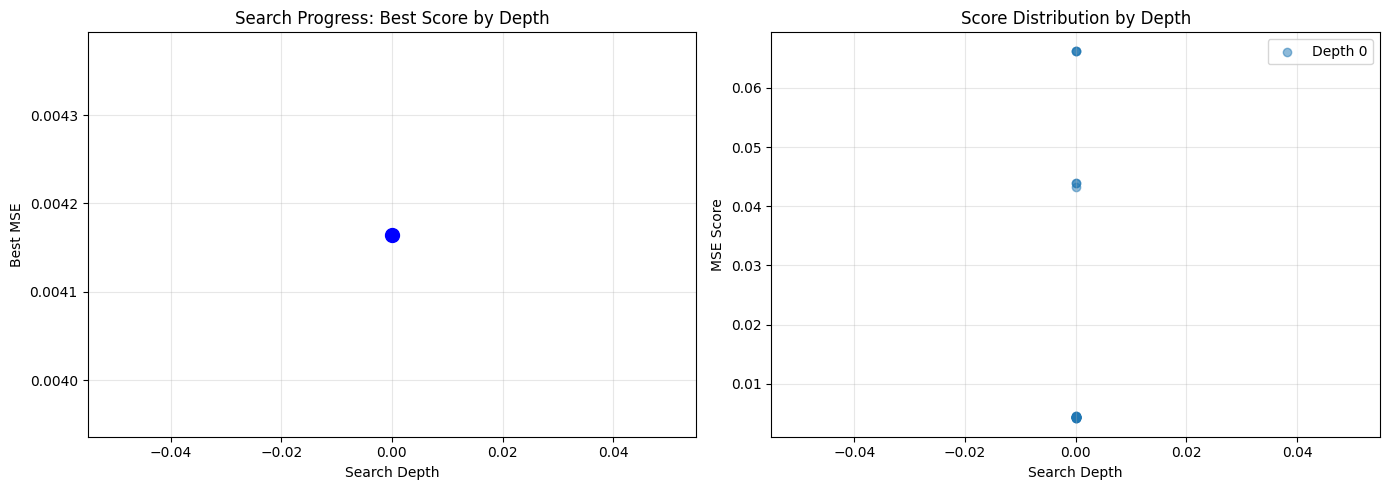

In [12]:
# Plot search progress
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Best score at each depth
depths = [h['depth'] for h in searcher.search_history]
scores = [h['best_score'] for h in searcher.search_history]
axes[0].plot(depths, scores, 'bo-', linewidth=2, markersize=10)
axes[0].set_xlabel('Search Depth')
axes[0].set_ylabel('Best MSE')
axes[0].set_title('Search Progress: Best Score by Depth')
axes[0].grid(True, alpha=0.3)

# Plot 2: Score distribution by depth
for depth in sorted(searcher.best_at_depth.keys()):
    nodes = searcher.best_at_depth[depth]
    scores = [n.score for n in nodes]
    axes[1].scatter([depth] * len(scores), scores, alpha=0.5, label=f'Depth {depth}')

axes[1].set_xlabel('Search Depth')
axes[1].set_ylabel('MSE Score')
axes[1].set_title('Score Distribution by Depth')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/pattern_search_progress.png', dpi=150, bbox_inches='tight')
plt.show()

Top 5 Patterns:

1. noise_coarse
   MSE: 0.004165, Depth: 0, Type: primitive


/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_34892/1899554538.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


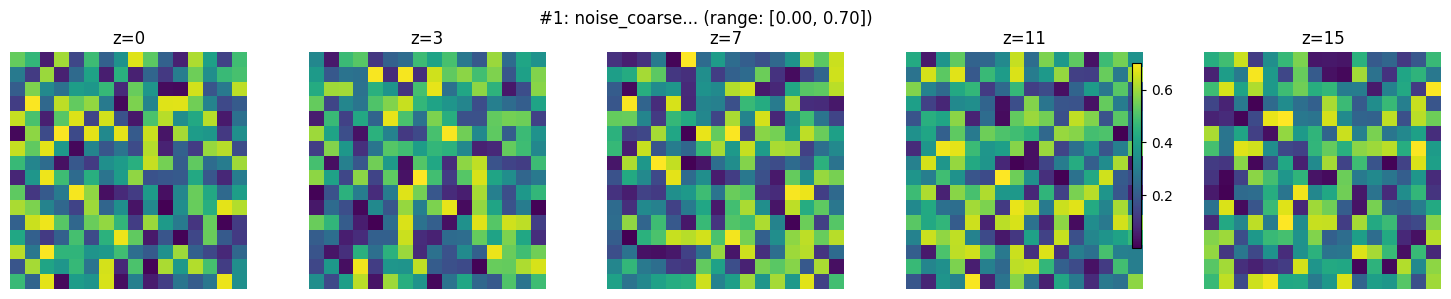


2. wave_spherical
   MSE: 0.004272, Depth: 0, Type: primitive


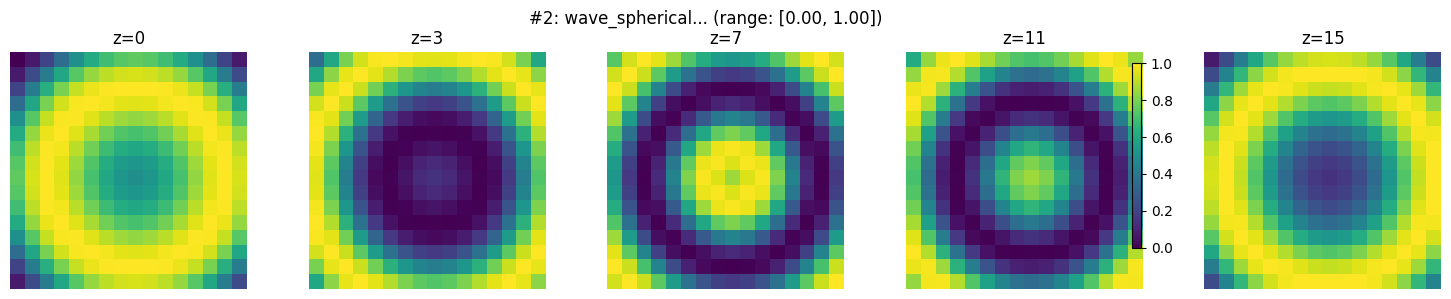


3. grad_y
   MSE: 0.004278, Depth: 0, Type: primitive


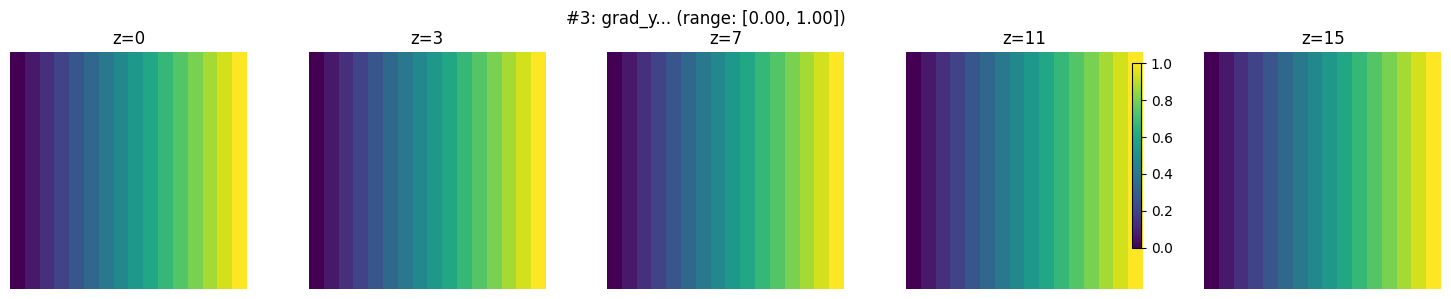


4. grad_radial
   MSE: 0.004304, Depth: 0, Type: primitive


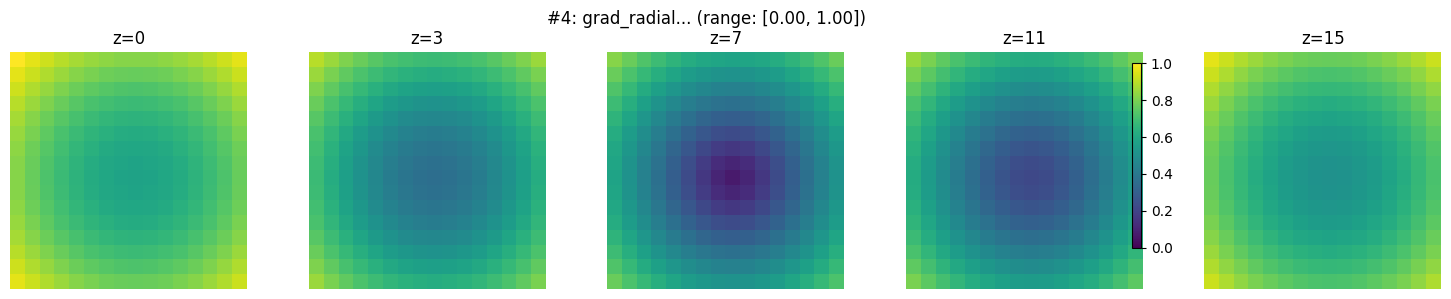


5. wave_z
   MSE: 0.004327, Depth: 0, Type: primitive


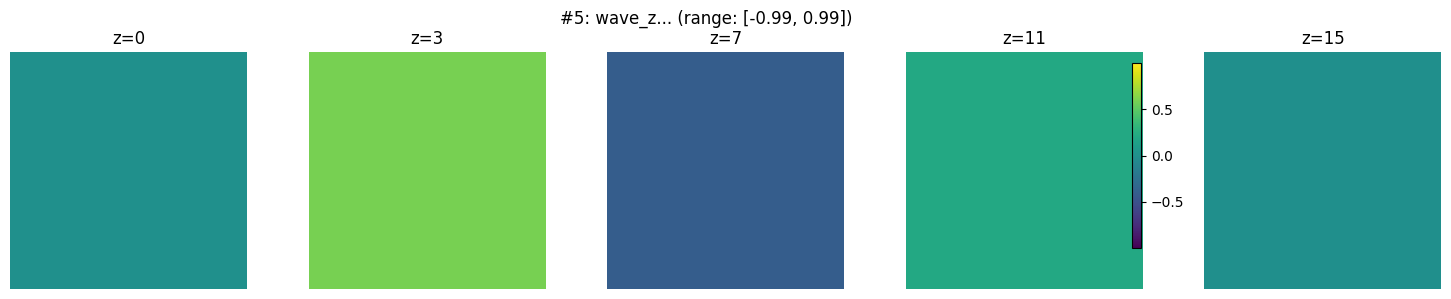

In [13]:
# Visualize top patterns
results = searcher.get_results_df()
top_n = 5

print(f"Top {top_n} Patterns:")
print("=" * 80)

for i, result in enumerate(results[:top_n]):
    node = searcher.all_evaluated[result['name']]
    print(f"\n{i+1}. {result['name']}")
    print(f"   MSE: {result['score']:.6f}, Depth: {result['depth']}, Type: {result['type']}")
    show_pattern_slices(node.pattern, f"#{i+1}: {result['name'][:40]}...")

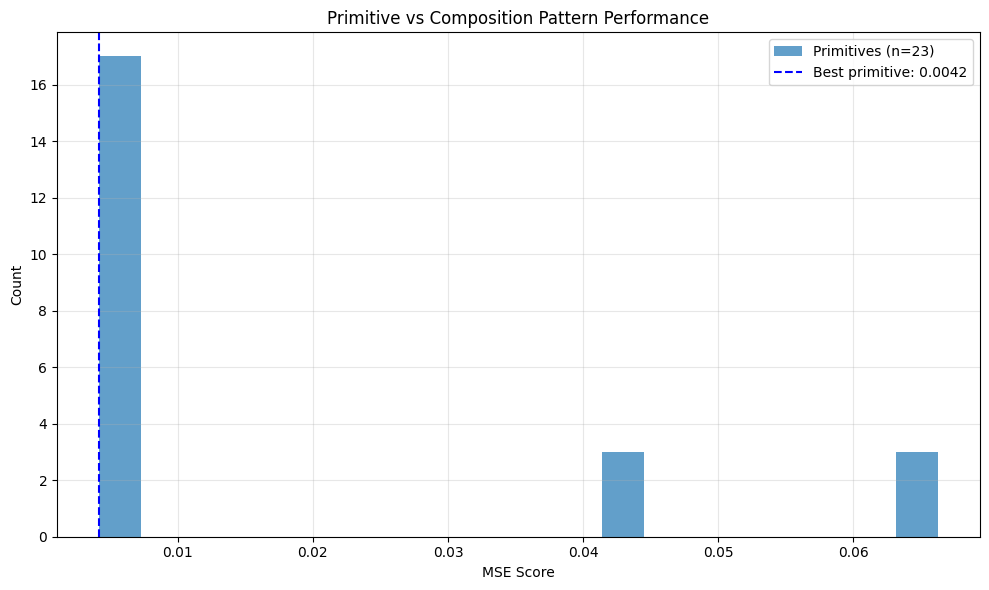

In [14]:
# Compare primitives vs compositions
primitive_scores = [r['score'] for r in results if r['type'] == 'primitive']
composition_scores = [r['score'] for r in results if r['type'] == 'composition']

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(primitive_scores, bins=20, alpha=0.7, label=f'Primitives (n={len(primitive_scores)})')
if composition_scores:
    ax.hist(composition_scores, bins=20, alpha=0.7, label=f'Compositions (n={len(composition_scores)})')

ax.axvline(min(primitive_scores), color='blue', linestyle='--', label=f'Best primitive: {min(primitive_scores):.4f}')
if composition_scores:
    ax.axvline(min(composition_scores), color='orange', linestyle='--', label=f'Best composition: {min(composition_scores):.4f}')

ax.set_xlabel('MSE Score')
ax.set_ylabel('Count')
ax.set_title('Primitive vs Composition Pattern Performance')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/pattern_search_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# Extract best pattern and results from searcher
results = searcher.get_results_df()
best_pattern = searcher.all_evaluated[results[0]['name']]

print(f"Best pattern: {best_pattern.name}")
print(f"Best MSE: {best_pattern.score:.6f}")
print(f"Total patterns evaluated: {len(searcher.all_evaluated)}")

Best pattern: noise_coarse
Best MSE: 0.004165
Total patterns evaluated: 23


## 8. Train Final Model with 5 Best Patterns distributed 

In [16]:
# Train a full model with the best pattern
print(f"Training final model with best pattern: {best_pattern.name}")
print("=" * 60)

# Create model with best pattern
pattern_weights = torch.from_numpy(best_pattern.pattern.data).float()

final_model = LatticeAutoencoder(
    input_dim=INPUT_DIM,
    output_dim=OUTPUT_DIM,
    lattice_shape=LATTICE_SHAPE,
    hidden_dim=HIDDEN_DIM,
    pattern_weights=pattern_weights
).to(device)

optimizer = torch.optim.AdamW(final_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 50)

# Extended training
FINAL_EPOCHS = 50
n_samples = len(train_data)
train_losses = []

final_model.train()
for epoch in tqdm(range(FINAL_EPOCHS), desc="Training"):
    indices = torch.randperm(n_samples)
    epoch_loss = 0.0
    n_batches = 0
    
    for i in range(0, n_samples, BATCH_SIZE):
        batch_idx = indices[i:i+BATCH_SIZE]
        batch = train_data[batch_idx].to(device)
        
        optimizer.zero_grad()
        reconstruction, _ = final_model(batch)
        loss = F.mse_loss(reconstruction, batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    scheduler.step()
    train_losses.append(epoch_loss / n_batches)

print(f"\nFinal training loss: {train_losses[-1]:.6f}")

Training final model with best pattern: noise_coarse


Training:   0%|          | 0/50 [00:00<?, ?it/s]


Final training loss: 0.001819


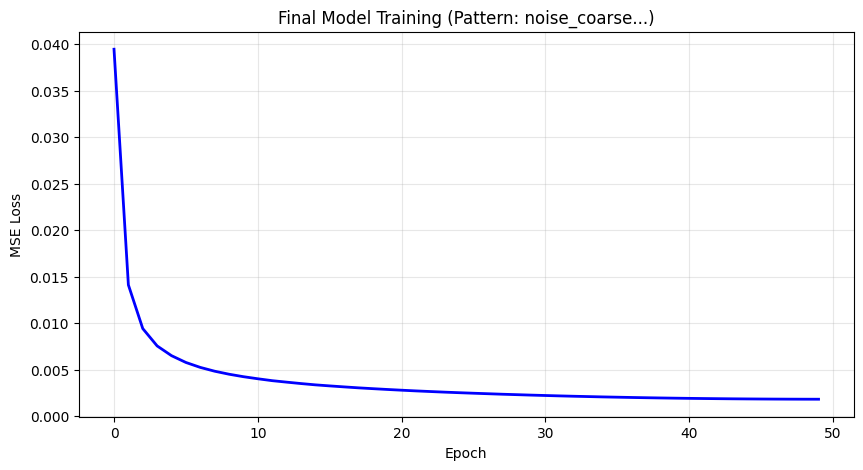

In [17]:
# Plot training curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title(f'Final Model Training (Pattern: {best_pattern.name[:40]}...)')
plt.grid(True, alpha=0.3)
plt.savefig('images/final_model_training.png', dpi=150, bbox_inches='tight')
plt.show()

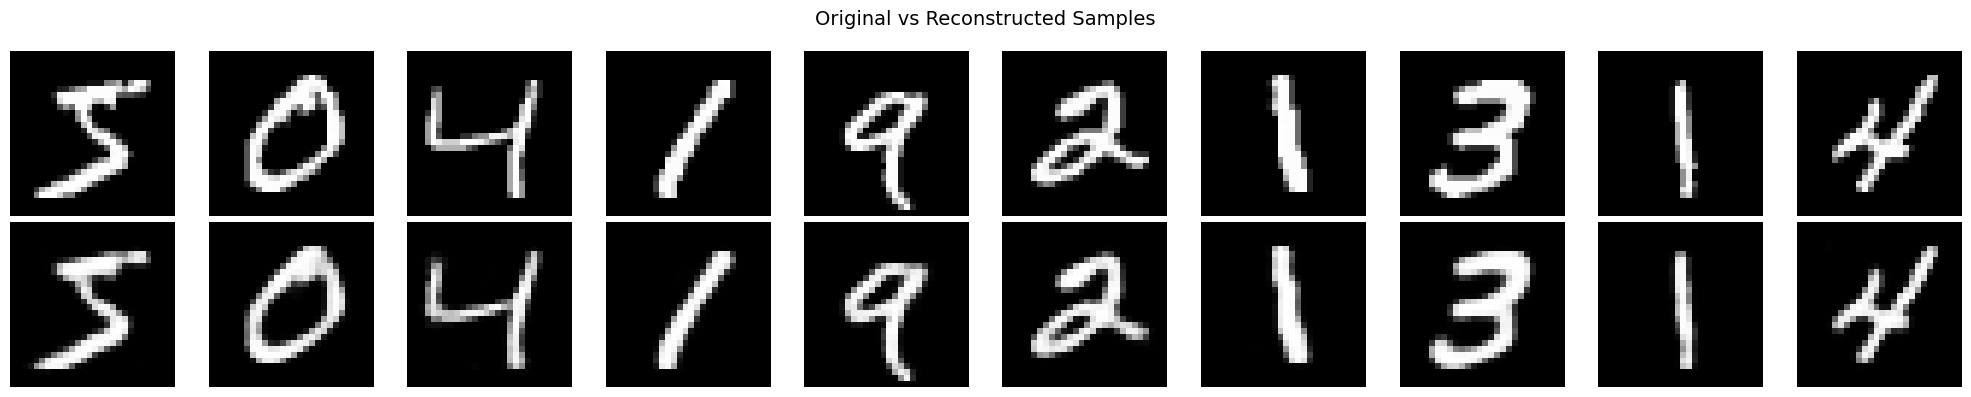

In [18]:
# Visualize reconstructions
final_model.eval()
with torch.no_grad():
    test_samples = train_data[:10].to(device)
    reconstructions, lattice_states = final_model(test_samples)

# Plot original vs reconstruction
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    # Original
    orig = test_samples[i].cpu().numpy().reshape(28, 28)
    axes[0, i].imshow(orig, cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=12)
    
    # Reconstruction
    recon = reconstructions[i].cpu().numpy().reshape(28, 28)
    axes[1, i].imshow(recon, cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Reconstructed', fontsize=12)

plt.suptitle('Original vs Reconstructed Samples', fontsize=14)
plt.tight_layout()
plt.savefig('images/final_reconstructions.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Multi-Layer Lattice Model with Top 5 Patterns

Train a model that uses the top 5 discovered patterns as separate lattice layers,
allowing the network to leverage multiple complementary pattern structures.

In [19]:
class MultiLayerLatticeAutoencoder(nn.Module):
    """Autoencoder with multiple lattice layers, each using a different pattern."""
    
    def __init__(self, input_dim: int, output_dim: int, 
                 lattice_shape: Tuple[int, ...], hidden_dim: int = 256,
                 pattern_weights_list: List[torch.Tensor] = None):
        super().__init__()
        self.lattice_shape = lattice_shape
        self.n_cells = np.prod(lattice_shape)
        self.n_layers = len(pattern_weights_list) if pattern_weights_list else 1
        
        # Encoder: maps input to activations for each lattice layer
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
        )
        
        # Separate projection heads for each lattice layer
        self.layer_projections = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, self.n_cells),
                nn.Sigmoid()
            ) for _ in range(self.n_layers)
        ])
        
        # Register pattern weights as buffers
        if pattern_weights_list:
            for i, pw in enumerate(pattern_weights_list):
                self.register_buffer(f'pattern_weights_{i}', pw.flatten())
        
        # Learnable layer combination weights
        self.layer_weights = nn.Parameter(torch.ones(self.n_layers) / self.n_layers)
        
        # Inter-layer connections (optional mixing between layers)
        self.inter_layer_mix = nn.Sequential(
            nn.Linear(self.n_cells * self.n_layers, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        batch_size = x.shape[0]
        
        # Encode
        encoded = self.encoder(x)
        
        # Project to each lattice layer and apply pattern modulation
        layer_states = []
        for i in range(self.n_layers):
            # Get activations for this layer
            activations = self.layer_projections[i](encoded)
            
            # Apply pattern modulation
            pattern_w = getattr(self, f'pattern_weights_{i}')
            modulated = activations * pattern_w.unsqueeze(0)
            layer_states.append(modulated)
        
        # Stack and combine layer states
        stacked_states = torch.stack(layer_states, dim=1)  # (batch, n_layers, n_cells)
        
        # Weighted combination
        weights = F.softmax(self.layer_weights, dim=0)
        weighted_states = stacked_states * weights.view(1, -1, 1)
        
        # Flatten for inter-layer mixing
        flat_states = stacked_states.view(batch_size, -1)
        mixed = self.inter_layer_mix(flat_states)
        
        # Decode
        reconstruction = self.decoder(mixed)
        
        return reconstruction, layer_states
    
    def get_layer_weights(self) -> torch.Tensor:
        """Get the normalized layer combination weights."""
        return F.softmax(self.layer_weights, dim=0)


print("MultiLayerLatticeAutoencoder defined!")

MultiLayerLatticeAutoencoder defined!


In [20]:
# Get top 5 patterns from search results
top_5_results = results[:5]
top_5_patterns = [searcher.all_evaluated[r['name']] for r in top_5_results]

print("Top 5 Patterns for Multi-Layer Model:")
print("=" * 60)
for i, (result, node) in enumerate(zip(top_5_results, top_5_patterns)):
    print(f"{i+1}. {result['name'][:50]}")
    print(f"   MSE: {result['score']:.6f}, Depth: {result['depth']}")

# Create pattern weight tensors
pattern_weights_list = [
    torch.from_numpy(node.pattern.data).float()
    for node in top_5_patterns
]

Top 5 Patterns for Multi-Layer Model:
1. noise_coarse
   MSE: 0.004165, Depth: 0
2. wave_spherical
   MSE: 0.004272, Depth: 0
3. grad_y
   MSE: 0.004278, Depth: 0
4. grad_radial
   MSE: 0.004304, Depth: 0
5. wave_z
   MSE: 0.004327, Depth: 0


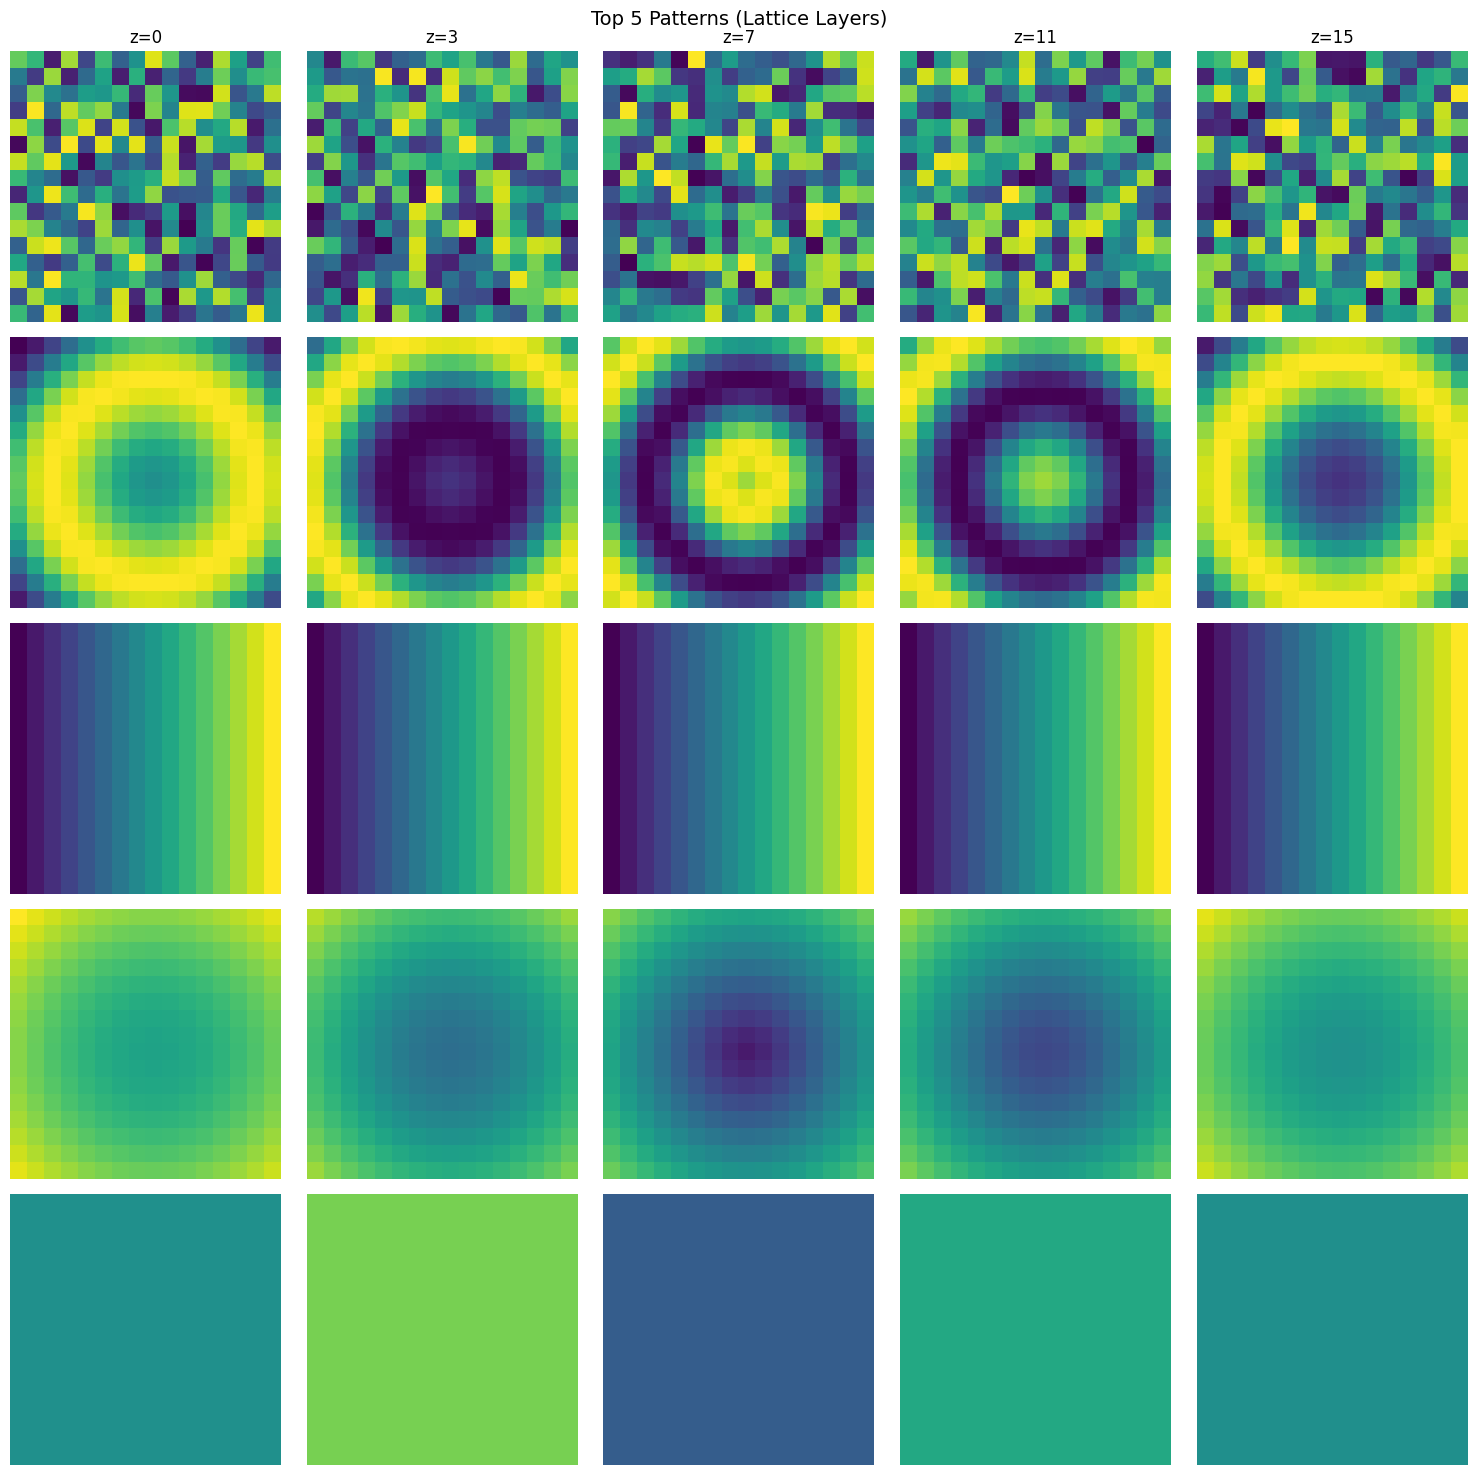

In [21]:
# Visualize the 5 patterns
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for row, (result, node) in enumerate(zip(top_5_results, top_5_patterns)):
    data = node.pattern.data
    slice_indices = [int(i) for i in np.linspace(0, data.shape[2]-1, 5)]
    
    for col, z in enumerate(slice_indices):
        im = axes[row, col].imshow(data[:, :, z], cmap='viridis', 
                                    vmin=data.min(), vmax=data.max())
        if col == 0:
            axes[row, col].set_ylabel(f'Pattern {row+1}', fontsize=10)
        if row == 0:
            axes[row, col].set_title(f'z={z}')
        axes[row, col].axis('off')

plt.suptitle('Top 5 Patterns (Lattice Layers)', fontsize=14)
plt.tight_layout()
plt.savefig('images/top5_pattern_layers.png', dpi=150, bbox_inches='tight')
plt.show()

In [22]:
# Create and train the multi-layer model
print("Training Multi-Layer Lattice Model")
print("=" * 60)

multi_layer_model = MultiLayerLatticeAutoencoder(
    input_dim=INPUT_DIM,
    output_dim=OUTPUT_DIM,
    lattice_shape=LATTICE_SHAPE,
    hidden_dim=HIDDEN_DIM,
    pattern_weights_list=pattern_weights_list
).to(device)

optimizer = torch.optim.AdamW(multi_layer_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)

# Extended training for multi-layer model
MULTI_LAYER_EPOCHS = 100
n_samples = len(train_data)
multi_layer_losses = []

multi_layer_model.train()
for epoch in tqdm(range(MULTI_LAYER_EPOCHS), desc="Training Multi-Layer"):
    indices = torch.randperm(n_samples)
    epoch_loss = 0.0
    n_batches = 0
    
    for i in range(0, n_samples, BATCH_SIZE):
        batch_idx = indices[i:i+BATCH_SIZE]
        batch = train_data[batch_idx].to(device)
        
        optimizer.zero_grad()
        reconstruction, layer_states = multi_layer_model(batch)
        
        # Main reconstruction loss
        recon_loss = F.mse_loss(reconstruction, batch)
        
        # Regularization: encourage layer diversity
        if len(layer_states) > 1:
            diversity_loss = 0.0
            for j in range(len(layer_states)):
                for k in range(j+1, len(layer_states)):
                    # Penalize high correlation between layers
                    corr = F.cosine_similarity(layer_states[j], layer_states[k], dim=1).mean()
                    diversity_loss += corr
            diversity_loss = diversity_loss / (len(layer_states) * (len(layer_states)-1) / 2)
        else:
            diversity_loss = 0.0
        
        loss = recon_loss + 0.01 * diversity_loss
        loss.backward()
        optimizer.step()
        
        epoch_loss += recon_loss.item()
        n_batches += 1
    
    scheduler.step()
    multi_layer_losses.append(epoch_loss / n_batches)
    
    if (epoch + 1) % 20 == 0:
        layer_w = multi_layer_model.get_layer_weights().detach().cpu().numpy()
        print(f"Epoch {epoch+1}: Loss={multi_layer_losses[-1]:.6f}, Layer weights={layer_w.round(3)}")

print(f"\nFinal training loss: {multi_layer_losses[-1]:.6f}")

Training Multi-Layer Lattice Model


Training Multi-Layer:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20: Loss=0.003536, Layer weights=[0.2 0.2 0.2 0.2 0.2]
Epoch 40: Loss=0.002344, Layer weights=[0.2 0.2 0.2 0.2 0.2]
Epoch 60: Loss=0.001809, Layer weights=[0.2 0.2 0.2 0.2 0.2]
Epoch 80: Loss=0.001520, Layer weights=[0.2 0.2 0.2 0.2 0.2]
Epoch 100: Loss=0.001428, Layer weights=[0.2 0.2 0.2 0.2 0.2]

Final training loss: 0.001428


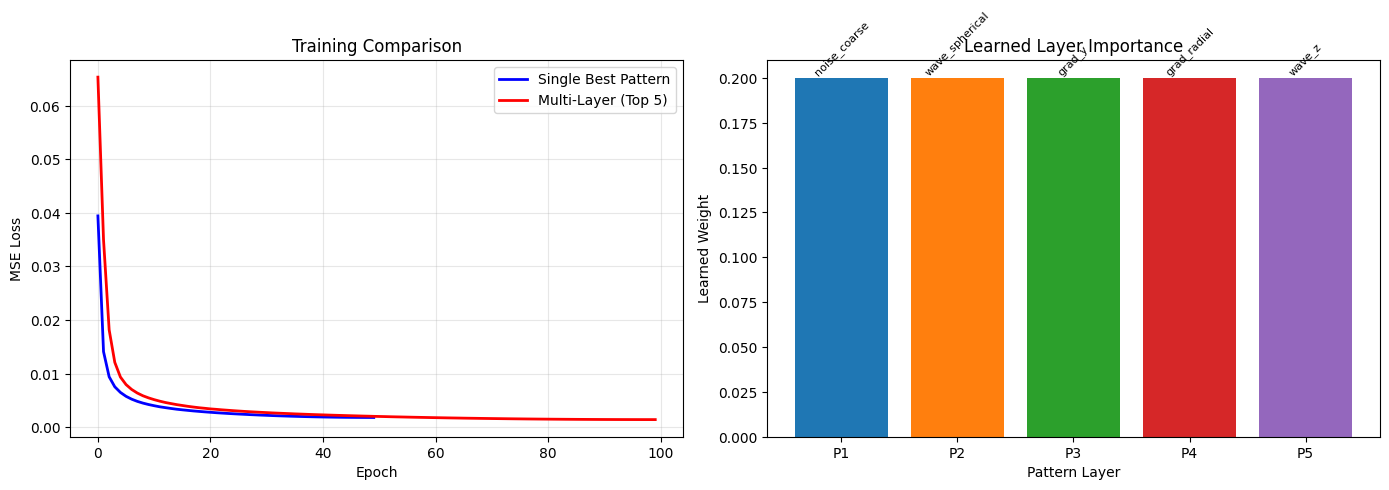


Single pattern final MSE: 0.001819
Multi-layer final MSE: 0.001428
Improvement: 21.51%


In [23]:
# Compare single-pattern vs multi-layer model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training curves
axes[0].plot(train_losses, 'b-', linewidth=2, label='Single Best Pattern')
axes[0].plot(multi_layer_losses, 'r-', linewidth=2, label='Multi-Layer (Top 5)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Layer weights evolution
layer_weights = multi_layer_model.get_layer_weights().detach().cpu().numpy()
bars = axes[1].bar(range(5), layer_weights, color=['C0', 'C1', 'C2', 'C3', 'C4'])
axes[1].set_xlabel('Pattern Layer')
axes[1].set_ylabel('Learned Weight')
axes[1].set_title('Learned Layer Importance')
axes[1].set_xticks(range(5))
axes[1].set_xticklabels([f'P{i+1}' for i in range(5)])

# Add pattern names as annotations
for i, (bar, result) in enumerate(zip(bars, top_5_results)):
    short_name = result['name'][:15] + '...' if len(result['name']) > 15 else result['name']
    axes[1].annotate(short_name, xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                     ha='center', va='bottom', fontsize=8, rotation=45)

plt.tight_layout()
plt.savefig('images/multi_layer_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSingle pattern final MSE: {train_losses[-1]:.6f}")
print(f"Multi-layer final MSE: {multi_layer_losses[-1]:.6f}")
improvement = (train_losses[-1] - multi_layer_losses[-1]) / train_losses[-1] * 100
print(f"Improvement: {improvement:.2f}%")

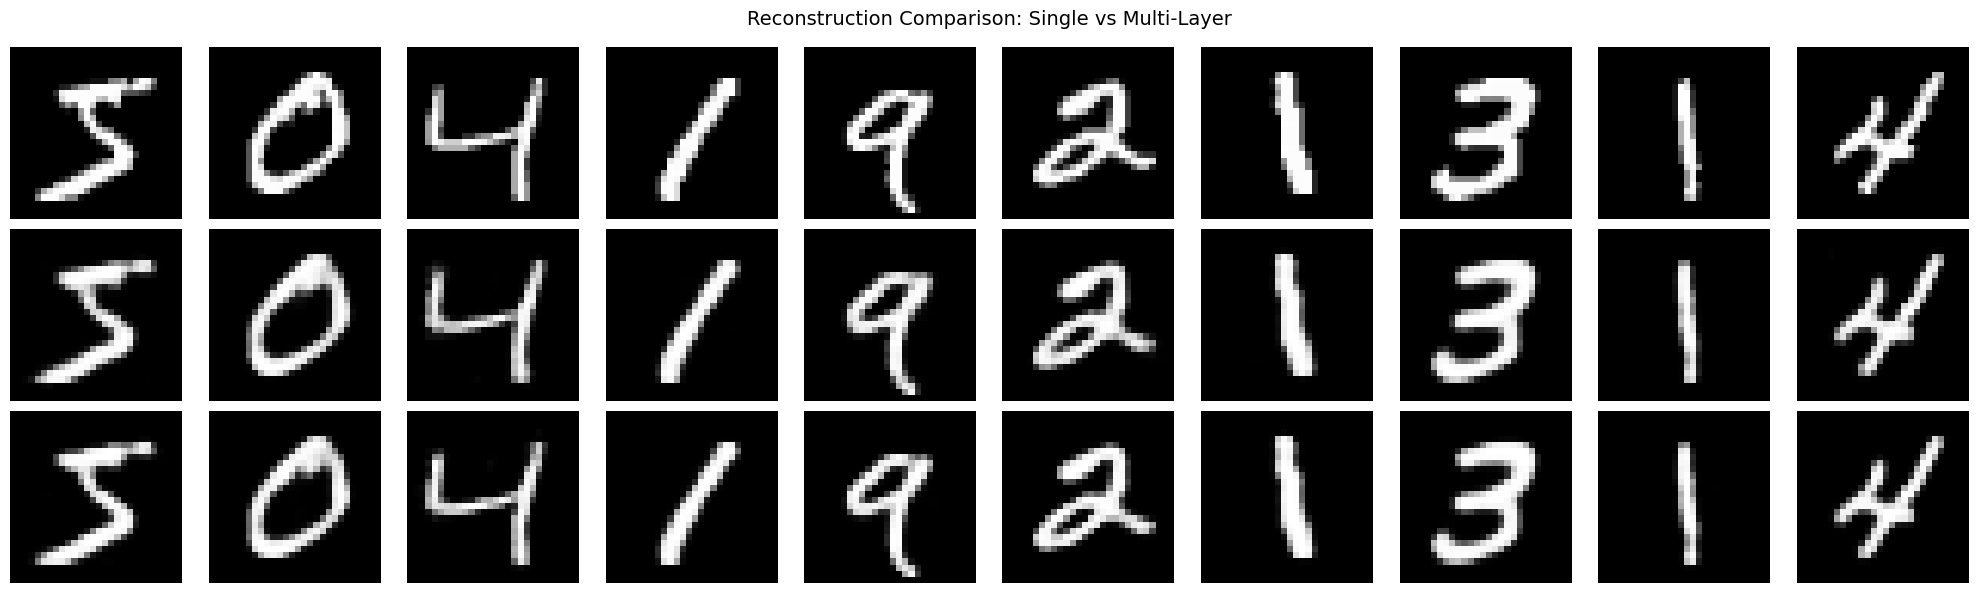

In [24]:
# Visualize multi-layer reconstructions
multi_layer_model.eval()
with torch.no_grad():
    test_samples = train_data[:10].to(device)
    ml_reconstructions, ml_layer_states = multi_layer_model(test_samples)

# Plot original vs multi-layer reconstruction
fig, axes = plt.subplots(3, 10, figsize=(20, 6))

for i in range(10):
    # Original
    orig = test_samples[i].cpu().numpy().reshape(28, 28)
    axes[0, i].imshow(orig, cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=12)
    
    # Single pattern reconstruction
    with torch.no_grad():
        single_recon, _ = final_model(test_samples[i:i+1])
    single_img = single_recon[0].cpu().numpy().reshape(28, 28)
    axes[1, i].imshow(single_img, cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Single Pattern', fontsize=12)
    
    # Multi-layer reconstruction
    ml_img = ml_reconstructions[i].cpu().numpy().reshape(28, 28)
    axes[2, i].imshow(ml_img, cmap='gray')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel('Multi-Layer', fontsize=12)

plt.suptitle('Reconstruction Comparison: Single vs Multi-Layer', fontsize=14)
plt.tight_layout()
plt.savefig('images/multi_layer_reconstructions.png', dpi=150, bbox_inches='tight')
plt.show()

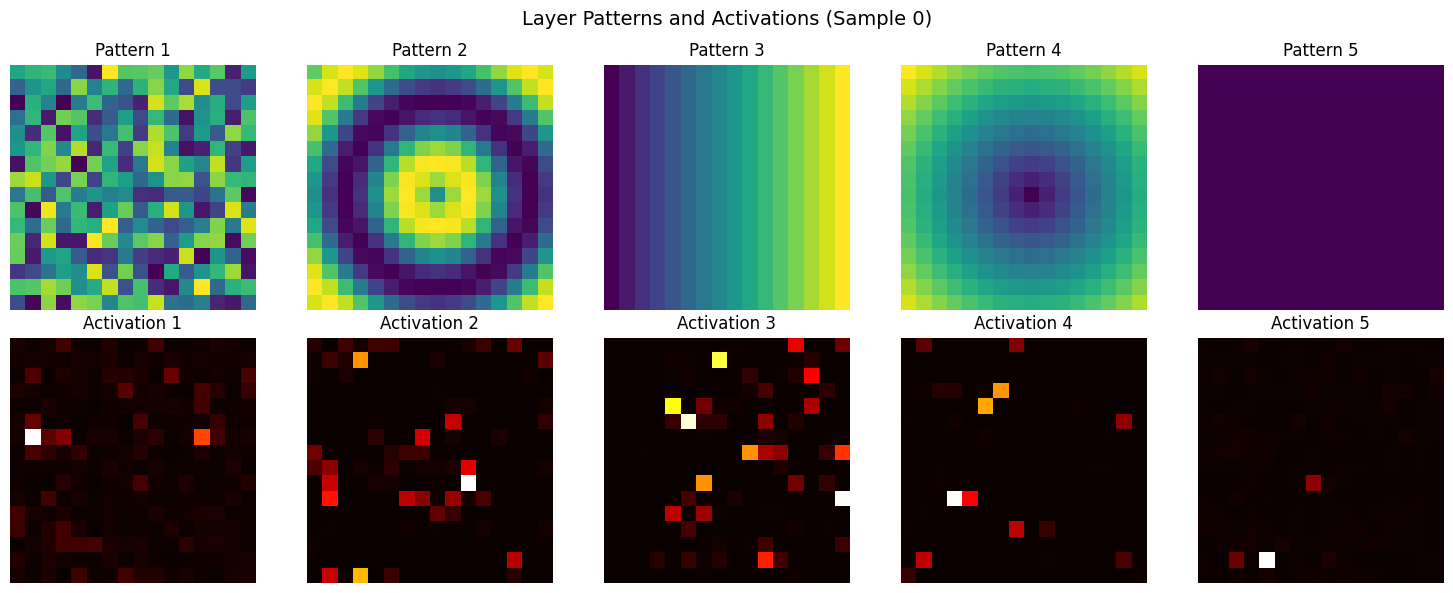

In [25]:
# Visualize layer activations for a sample
sample_idx = 0
sample = train_data[sample_idx:sample_idx+1].to(device)

with torch.no_grad():
    _, layer_states = multi_layer_model(sample)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Top row: pattern weights
# Bottom row: activations for this sample
for i, (node, state) in enumerate(zip(top_5_patterns, layer_states)):
    # Pattern (middle slice)
    z_mid = LATTICE_SHAPE[2] // 2
    axes[0, i].imshow(node.pattern.data[:, :, z_mid], cmap='viridis')
    axes[0, i].set_title(f'Pattern {i+1}')
    axes[0, i].axis('off')
    
    # Activation (reshaped to lattice, middle slice)
    activation = state[0].cpu().numpy().reshape(LATTICE_SHAPE)
    axes[1, i].imshow(activation[:, :, z_mid], cmap='hot')
    axes[1, i].set_title(f'Activation {i+1}')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Pattern\nWeights', fontsize=10)
axes[1, 0].set_ylabel('Sample\nActivations', fontsize=10)

plt.suptitle(f'Layer Patterns and Activations (Sample {sample_idx})', fontsize=14)
plt.tight_layout()
plt.savefig('images/layer_activations.png', dpi=150, bbox_inches='tight')
plt.show()

In [26]:
# 3D Visualization of Layer Patterns and Activations
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_3d_volume(data, title, colorscale='Viridis', opacity=0.3, threshold=0.2):
    """Create a 3D volume visualization using isosurface."""
    d1, d2, d3 = data.shape
    
    # Create coordinate grids
    X, Y, Z = np.mgrid[0:d1, 0:d2, 0:d3]
    
    # Normalize data to [0, 1]
    data_norm = (data - data.min()) / (data.max() - data.min() + 1e-8)
    
    # Create isosurface
    fig = go.Figure(data=go.Isosurface(
        x=X.flatten(),
        y=Y.flatten(),
        z=Z.flatten(),
        value=data_norm.flatten(),
        isomin=threshold,
        isomax=1.0,
        opacity=opacity,
        surface_count=5,
        colorscale=colorscale,
        caps=dict(x_show=False, y_show=False, z_show=False)
    ))
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        ),
        width=600,
        height=500
    )
    return fig

print("3D visualization functions defined!")

3D visualization functions defined!


In [36]:
# Visualize each layer's pattern and activation in 3D
sample_idx = 0
sample = train_data[sample_idx:sample_idx+1].to(device)

with torch.no_grad():
    _, layer_states = multi_layer_model(sample)

# Select which layer to visualize (0-4)
layer_idx = 0  # Change this to view different layers

node = top_5_patterns[layer_idx]
state = layer_states[layer_idx]

# Pattern 3D visualization
pattern_fig = create_3d_volume(
    node.pattern.data, 
    f'Pattern {layer_idx+1}: {top_5_results[layer_idx]["name"][:30]}...',
    colorscale='Viridis',
    threshold=0.3
)
pattern_fig.show()

# Activation 3D visualization
activation = state[0].cpu().numpy().reshape(LATTICE_SHAPE)
activation_fig = create_3d_volume(
    activation,
    f'Activation {layer_idx+1} (Sample {sample_idx})',
    colorscale='Hot',
    threshold=0.2
)
activation_fig.show()

In [28]:
# Combined 3D view: All 5 patterns side by side
fig = make_subplots(
    rows=2, cols=5,
    specs=[[{'type': 'scene'}] * 5, [{'type': 'scene'}] * 5],
    subplot_titles=[
        'Pattern 1', 'Pattern 2', 'Pattern 3', 'Pattern 4', 'Pattern 5',
        'Activation 1', 'Activation 2', 'Activation 3', 'Activation 4', 'Activation 5'
    ],
    horizontal_spacing=0.02,
    vertical_spacing=0.08
)

for i, (node, state) in enumerate(zip(top_5_patterns, layer_states)):
    # Pattern data
    pattern_data = node.pattern.data
    pattern_norm = (pattern_data - pattern_data.min()) / (pattern_data.max() - pattern_data.min() + 1e-8)
    
    # Activation data
    activation = state[0].cpu().numpy().reshape(LATTICE_SHAPE)
    activation_norm = (activation - activation.min()) / (activation.max() - activation.min() + 1e-8)
    
    d1, d2, d3 = LATTICE_SHAPE
    X, Y, Z = np.mgrid[0:d1, 0:d2, 0:d3]
    
    # Add pattern isosurface
    fig.add_trace(
        go.Isosurface(
            x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
            value=pattern_norm.flatten(),
            isomin=0.3, isomax=1.0,
            opacity=0.4,
            surface_count=3,
            colorscale='Viridis',
            showscale=False,
            caps=dict(x_show=False, y_show=False, z_show=False)
        ),
        row=1, col=i+1
    )
    
    # Add activation isosurface
    fig.add_trace(
        go.Isosurface(
            x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
            value=activation_norm.flatten(),
            isomin=0.2, isomax=1.0,
            opacity=0.4,
            surface_count=3,
            colorscale='Hot',
            showscale=False,
            caps=dict(x_show=False, y_show=False, z_show=False)
        ),
        row=2, col=i+1
    )

fig.update_layout(
    title=f'All 5 Lattice Layers: Patterns (top) vs Activations (bottom) - Sample {sample_idx}',
    height=800,
    width=1500,
    showlegend=False
)

# Update all scenes
for i in range(1, 11):
    fig.update_scenes(aspectmode='cube', row=(i-1)//5 + 1, col=(i-1)%5 + 1)

fig.show()

In [34]:
# Interactive 3D scatter plot of high-activation voxels
def plot_3d_scatter(data, title, threshold_percentile=80, colorscale='Viridis'):
    """Plot voxels above threshold as 3D scatter points."""
    threshold = np.percentile(data, threshold_percentile)
    
    # Get coordinates of high-value voxels
    coords = np.where(data > threshold)
    values = data[coords]
    
    fig = go.Figure(data=go.Scatter3d(
        x=coords[0],
        y=coords[1],
        z=coords[2],
        mode='markers',
        marker=dict(
            size=4,
            color=values,
            colorscale=colorscale,
            opacity=0.8,
            colorbar=dict(title='Value')
        )
    ))
    
    fig.update_layout(
        title=f'{title} (top {100-threshold_percentile}% voxels)',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y', 
            zaxis_title='Z',
            aspectmode='cube'
        ),
        width=700,
        height=600
    )
    return fig

# Show combined activations from all layers
combined_activation = np.zeros(LATTICE_SHAPE)
layer_weights = multi_layer_model.get_layer_weights().detach().cpu().numpy()

for i, state in enumerate(layer_states):
    activation = state[0].cpu().numpy().reshape(LATTICE_SHAPE)
    combined_activation += layer_weights[i] * activation

fig = plot_3d_scatter(combined_activation, 'Combined Weighted Activations', threshold_percentile=70)
fig.show()

print(f"Layer weights: {layer_weights.round(3)}")

Layer weights: [0.2 0.2 0.2 0.2 0.2]


In [35]:
# Save multi-layer model
torch.save(multi_layer_model.state_dict(), 'multi_layer_model.pt')

# Save top 5 patterns
top_5_data = {
    'patterns': [node.pattern.data for node in top_5_patterns],
    'names': [r['name'] for r in top_5_results],
    'scores': [r['score'] for r in top_5_results],
    'learned_weights': multi_layer_model.get_layer_weights().detach().cpu().numpy().tolist()
}
np.savez('top5_patterns.npz', **{f'pattern_{i}': p for i, p in enumerate(top_5_data['patterns'])})

print("Saved:")
print("  - multi_layer_model.pt")
print("  - top5_patterns.npz")

Saved:
  - multi_layer_model.pt
  - top5_patterns.npz


## 10. Summary and Export

In [31]:
# Print summary
print("=" * 60)
print("SEARCH SUMMARY")
print("=" * 60)
print(f"\nConfiguration:")
print(f"  Lattice shape: {LATTICE_SHAPE}")
print(f"  Topology: {TOPOLOGY}")
print(f"  Search depth: {MAX_SEARCH_DEPTH}")
print(f"  Beam width: {BEAM_WIDTH}")
print(f"\nResults:")
print(f"  Total patterns evaluated: {len(searcher.all_evaluated)}")
print(f"  Best pattern: {best_pattern.name}")
print(f"  Best MSE: {best_pattern.score:.6f}")
print(f"  Pattern depth: {best_pattern.depth}")
print(f"\nFinal model performance:")
print(f"  Final training MSE: {train_losses[-1]:.6f}")

SEARCH SUMMARY

Configuration:
  Lattice shape: (16, 16, 16)
  Topology: toroidal
  Search depth: 3
  Beam width: 5

Results:
  Total patterns evaluated: 23
  Best pattern: noise_coarse
  Best MSE: 0.004165
  Pattern depth: 0

Final model performance:
  Final training MSE: 0.001819


In [32]:
# Save best pattern and model
import json

# Save search results
search_results = {
    'config': {
        'lattice_shape': LATTICE_SHAPE,
        'topology': TOPOLOGY,
        'connectivity': CONNECTIVITY,
        'search_depth': MAX_SEARCH_DEPTH,
        'beam_width': BEAM_WIDTH,
    },
    'best_pattern': {
        'name': best_pattern.name,
        'score': best_pattern.score,
        'depth': best_pattern.depth,
        'params': best_pattern.params
    },
    'top_10': [
        {'name': r['name'], 'score': r['score'], 'depth': r['depth']}
        for r in results[:10]
    ],
    'search_history': searcher.search_history
}

with open('pattern_search_results.json', 'w') as f:
    json.dump(search_results, f, indent=2)

# Save best pattern as numpy array
np.save('best_pattern.npy', best_pattern.pattern.data)

# Save model
torch.save(final_model.state_dict(), 'best_pattern_model.pt')

print("Saved:")
print("  - pattern_search_results.json")
print("  - best_pattern.npy")
print("  - best_pattern_model.pt")

Saved:
  - pattern_search_results.json
  - best_pattern.npy
  - best_pattern_model.pt
